In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [9]:
RANDOM_STATE = 42

numeric_columns = [
    'price', 'accommodates', 'bedrooms', 'beds', 'bathrooms_text',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'maximum_nights'
]

def clean_bathrooms(df):
    """
    Safely convert bathrooms_text to numeric by extracting the number
    and handling formats like '1 bath', '1.5 shared baths', 'Half-bath'.
    """
    col = df['bathrooms_text'].astype(str).str.lower()

    # Replace half-bath variations
    col = col.str.replace("half-bath", "0.5", regex=False)
    col = col.str.replace("half bath", "0.5", regex=False)

    # Extract leading numeric token
    extracted = col.str.extract(r'(\d+(\.\d+)?)')
    df['bathrooms_text'] = pd.to_numeric(extracted[0], errors='coerce')

    return df


def remove_outliers_iqr(df, cols):
    """
    Safer outlier removal: trims only extreme 1% and 99% values per column.
    Does NOT wipe out entire dataset.
    """
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        df_clean = df_clean[(df_clean[col] >= Q1) & (df_clean[col] <= Q3)]
    return df_clean


def preprocess_city(df_raw, city_name):
    """
    Full preprocessing pipeline with minimal fixes:
    - Clean price
    - Restrict to required numeric columns
    - Clean bathrooms_text
    - Convert numeric
    - Median imputation
    - Safe IQR trimming
    - Standard scaling
    """

    df = df_raw.copy()

    # --- Clean price column ---
    if 'price' in df.columns:
        df['price'] = (
            df['price']
            .astype(str)
            .str.replace('$', '', regex=False)
            .str.replace(',', '', regex=False)
        )

    # --- Restrict to required numeric columns ---
    df = df[numeric_columns].copy()

    # --- Clean bathrooms_text ---
    df = clean_bathrooms(df)

    # --- Convert all to numeric ---
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- Median fill ---
    df = df.fillna(df.median(numeric_only=True))

    # --- Outlier removal using per-column IQR ---
    df = remove_outliers_iqr(df, numeric_columns)

    print(f"[{city_name}] Final shape after cleaning: {df.shape}")

    # --- Standard scaling ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[numeric_columns])

    return df, X_scaled, scaler


**Section 1: Data Loading & Preprocessing**

In this section, I load Airbnb listing datasets for the four cities, restrict the analysis to the required numeric columns, convert bathrooms_text into a numeric feature, handle missing values via median imputation, remove obvious outliers using a z-score rule, and apply StandardScaler to normalize all numeric features. I also show basic summary statistics to verify that preprocessing behaved as expected.

In [12]:
# =======================
# SECTION 1: DATA LOADING & PREPROCESSING
# =======================

from IPython.display import display

# File paths (CSV files must be in the same directory as the notebook)
city_files = {
    "Portland": "portland_listings.csv",
    "Pacific Grove": "pacificigrove_listings.csv",
    "Albany": "albany_listing.csv",
    "Bozeman": "bozeman_listings.csv"
}

# Dictionary to store all outputs for later PCA and clustering
city_results = {}

print("=== SECTION 1: DATA LOADING & PREPROCESSING ===")

for city, path in city_files.items():
    print(f"\n==============================")
    print(f"    {city}: Loading Dataset")
    print(f"==============================")

    # Load CSV
    df_raw = pd.read_csv(path)
    print(f"[{city}] Raw shape: {df_raw.shape}")

    # Show pre-cleaning numeric statistics
    print(f"\n[{city}] Summary BEFORE Cleaning:")
    display(df_raw[numeric_columns].describe(include='all'))

    # Run preprocessing
    df_clean, X_scaled, scaler = preprocess_city(df_raw, city)

    # Show cleaned statistics
    print(f"\n[{city}] Summary AFTER Cleaning:")
    display(df_clean.describe())

    # Store results
    city_results[city] = {
        "df_raw": df_raw,
        "df_clean": df_clean,
        "X_scaled": X_scaled,
        "scaler": scaler
    }

print("\n=== Section 1 Complete: All datasets loaded and preprocessed ===")


=== SECTION 1: DATA LOADING & PREPROCESSING ===

    Portland: Loading Dataset
[Portland] Raw shape: (4425, 79)

[Portland] Summary BEFORE Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,3798,4425.000000,4300.000000,3826.000000,4402,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,4425.000000,4425.000000,4425.000000,4425.000000
unique,443,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,$100.00,NaN,NaN,NaN,1 bath,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,54,NaN,NaN,NaN,2830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.619435,1.514186,1.946681,NaN,4.861832,4.879646,4.853051,4.920946,4.917793,4.853549,4.794776,109.522260,214.259887,14.028475,376.064181
std,NaN,2.206923,1.065011,1.415611,NaN,0.265132,0.260983,0.273148,0.243848,0.248364,0.257320,0.289903,169.578949,126.977619,21.910204,396.789579
min,NaN,1.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,NaN,2.000000,1.000000,1.000000,NaN,4.830000,4.870000,4.830000,4.930000,4.930000,4.830000,4.750000,4.000000,97.000000,1.000000,30.000000
50%,NaN,3.000000,1.000000,2.000000,NaN,4.930000,4.950000,4.930000,4.970000,4.970000,4.920000,4.860000,36.000000,244.000000,2.000000,365.000000
75%,NaN,4.000000,2.000000,2.000000,NaN,4.990000,4.990000,4.990000,5.000000,5.000000,4.980000,4.930000,139.000000,335.000000,30.000000,365.000000


[Portland] Final shape after cleaning: (3920, 16)

[Portland] Summary AFTER Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,133.699490,3.502551,1.445153,1.888010,1.258418,4.904691,4.922099,4.897140,4.954018,4.953574,4.893837,4.845548,110.017602,210.157143,12.757908,367.814541
std,87.582548,1.814431,0.914878,1.022562,0.527073,0.106710,0.097085,0.128622,0.066407,0.068537,0.117591,0.120434,151.179572,127.244875,14.150516,396.560735
min,39.000000,1.000000,0.000000,0.000000,1.000000,4.000000,4.140000,4.000000,4.500000,4.500000,4.250000,4.290000,0.000000,0.000000,1.000000,5.000000
25%,86.000000,2.000000,1.000000,1.000000,1.000000,4.870000,4.900000,4.870000,4.940000,4.950000,4.870000,4.800000,6.000000,90.000000,1.000000,30.000000
50%,110.000000,3.000000,1.000000,2.000000,1.000000,4.930000,4.950000,4.930000,4.970000,4.970000,4.920000,4.860000,44.000000,240.000000,2.000000,360.000000
75%,149.000000,4.000000,2.000000,2.000000,1.000000,4.980000,4.980000,4.980000,5.000000,5.000000,4.970000,4.920000,148.000000,333.000000,30.000000,365.000000
max,1141.000000,12.000000,5.000000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,799.000000,365.000000,60.000000,1125.000000



    Pacific Grove: Loading Dataset
[Pacific Grove] Raw shape: (300, 79)

[Pacific Grove] Summary BEFORE Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,275,300.000000,299.000000,275.000000,300,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,300.000000,300.000000,300.000000,300.000000
unique,210,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,$250.00,NaN,NaN,NaN,1 bath,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.350000,2.013378,2.480000,NaN,4.856395,4.866395,4.885279,4.922790,4.894678,4.917725,4.705536,83.393333,206.116667,13.386667,354.020000
std,NaN,2.176378,1.052237,1.373152,NaN,0.258583,0.224367,0.221515,0.174574,0.222900,0.311148,0.288260,173.812989,104.001044,14.845373,366.330963
min,NaN,1.000000,0.000000,0.000000,NaN,2.000000,3.000000,2.500000,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,1.000000,4.000000
25%,NaN,2.000000,1.000000,1.000000,NaN,4.810000,4.830000,4.850000,4.900000,4.860000,4.920000,4.610000,1.000000,136.000000,1.000000,45.000000
50%,NaN,4.000000,2.000000,2.000000,NaN,4.920000,4.930000,4.950000,4.970000,4.960000,4.980000,4.750000,13.500000,222.000000,2.000000,365.000000
75%,NaN,6.000000,3.000000,3.000000,NaN,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.860000,75.000000,291.000000,30.000000,365.000000


[Pacific Grove] Final shape after cleaning: (259, 16)

[Pacific Grove] Summary AFTER Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,343.853282,4.181467,1.926641,2.308880,1.527027,4.898687,4.901776,4.920270,4.947799,4.927143,4.964286,4.743475,75.613900,203.563707,12.150579,359.393822
std,180.085170,1.872352,0.935116,1.115934,0.631262,0.102204,0.112835,0.097882,0.066334,0.094927,0.050369,0.151021,142.159254,103.752159,13.780270,370.974601
min,81.000000,1.000000,0.000000,0.000000,1.000000,4.500000,4.330000,4.220000,4.700000,4.500000,4.760000,4.250000,0.000000,0.000000,1.000000,7.000000
25%,231.000000,2.000000,1.000000,1.000000,1.000000,4.850000,4.870000,4.890000,4.930000,4.900000,4.960000,4.650000,1.000000,136.000000,1.000000,45.000000
50%,302.000000,4.000000,2.000000,2.000000,1.000000,4.920000,4.930000,4.950000,4.970000,4.960000,4.980000,4.750000,15.000000,222.000000,2.000000,365.000000
75%,413.500000,6.000000,3.000000,3.000000,2.000000,4.990000,4.980000,4.990000,5.000000,5.000000,5.000000,4.820000,71.000000,288.500000,30.000000,365.000000
max,1024.000000,10.000000,4.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,806.000000,360.000000,31.000000,1125.000000



    Albany: Loading Dataset
[Albany] Raw shape: (461, 79)

[Albany] Summary BEFORE Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,425,461.000000,453.000000,425.000000,461,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,461.000000,461.000000,461.000000,461.000000
unique,166,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,$92.00,NaN,NaN,NaN,1 bath,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,NaN,NaN,NaN,285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.444685,1.598234,1.837647,NaN,4.717425,4.769975,4.734025,4.835375,4.854875,4.620800,4.695900,60.442516,239.746204,7.104121,487.281996
std,NaN,2.461812,1.099958,1.315544,NaN,0.469403,0.391244,0.432773,0.371382,0.330482,0.482058,0.465833,111.350599,122.642316,22.227431,396.109189
min,NaN,1.000000,0.000000,0.000000,NaN,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,NaN,2.000000,1.000000,1.000000,NaN,4.670000,4.750000,4.670000,4.830000,4.850000,4.480000,4.640000,3.000000,138.000000,1.000000,300.000000
50%,NaN,2.000000,1.000000,1.000000,NaN,4.850000,4.895000,4.860000,4.940000,4.960000,4.780000,4.810000,20.000000,272.000000,2.000000,365.000000
75%,NaN,4.000000,2.000000,2.000000,NaN,4.970000,4.980000,4.980000,5.000000,5.000000,4.930000,4.940000,70.000000,350.000000,3.000000,730.000000


[Albany] Final shape after cleaning: (393, 16)

[Albany] Summary AFTER Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,105.567430,3.274809,1.508906,1.674300,1.175573,4.816489,4.857913,4.813613,4.907506,4.921425,4.710611,4.792926,59.089059,243.010178,5.351145,493.796438
std,55.769946,2.045603,0.931614,1.076548,0.408411,0.209646,0.166417,0.207828,0.115725,0.110019,0.287228,0.185472,87.458764,121.269959,8.501432,397.614666
min,39.000000,1.000000,0.000000,0.000000,1.000000,3.000000,4.000000,4.000000,4.250000,4.250000,3.580000,4.000000,0.000000,0.000000,1.000000,10.000000
25%,70.000000,2.000000,1.000000,1.000000,1.000000,4.750000,4.820000,4.750000,4.870000,4.880000,4.600000,4.720000,3.000000,143.000000,1.000000,300.000000
50%,94.000000,2.000000,1.000000,1.000000,1.000000,4.850000,4.895000,4.860000,4.940000,4.960000,4.780000,4.810000,25.000000,277.000000,2.000000,365.000000
75%,120.000000,4.000000,2.000000,2.000000,1.000000,4.970000,4.970000,4.970000,4.990000,5.000000,4.920000,4.940000,77.000000,350.000000,3.000000,800.000000
max,555.000000,12.000000,5.000000,6.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,523.000000,365.000000,31.000000,1125.000000



    Bozeman: Loading Dataset
[Bozeman] Raw shape: (580, 79)

[Bozeman] Summary BEFORE Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,526,580.000000,577.000000,526.000000,580,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,580.000000,580.000000,580.000000,580.000000
unique,245,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,$120.00,NaN,NaN,NaN,1 bath,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,NaN,NaN,NaN,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.532759,2.012132,2.541825,NaN,4.913638,4.914612,4.921054,4.939602,4.939702,4.916024,4.806680,81.394828,223.386207,10.715517,481.817241
std,NaN,2.238915,1.053199,1.484254,NaN,0.140942,0.167496,0.134362,0.100947,0.125898,0.154791,0.214337,123.078493,118.980960,22.132357,425.122676
min,NaN,1.000000,0.000000,0.000000,NaN,4.000000,3.000000,3.790000,4.100000,4.000000,3.000000,3.000000,0.000000,0.000000,1.000000,4.000000
25%,NaN,3.000000,1.000000,2.000000,NaN,4.900000,4.900000,4.905000,4.920000,4.930000,4.900000,4.760000,4.000000,128.750000,1.000000,90.000000
50%,NaN,4.000000,2.000000,2.000000,NaN,4.960000,4.960000,4.960000,4.970000,4.980000,4.950000,4.860000,38.000000,262.000000,2.000000,365.000000
75%,NaN,6.000000,3.000000,3.000000,NaN,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.920000,103.000000,328.000000,28.000000,1125.000000


[Bozeman] Final shape after cleaning: (491, 16)

[Bozeman] Summary AFTER Cleaning:


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.00000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,183.160896,4.391039,1.938900,2.421589,1.582485,4.939735,4.944297,4.941772,4.95556,4.964196,4.941039,4.850978,79.340122,223.002037,9.213849,481.859470
std,88.581454,1.788239,0.919369,1.196706,0.687957,0.074558,0.069188,0.074770,0.05366,0.049606,0.060349,0.111991,108.154842,119.956361,12.250160,425.653393
min,52.000000,2.000000,0.000000,0.000000,1.000000,4.500000,4.500000,4.530000,4.68000,4.750000,4.630000,4.330000,0.000000,0.000000,1.000000,8.000000
25%,126.000000,3.000000,1.000000,2.000000,1.000000,4.930000,4.930000,4.930000,4.94000,4.960000,4.920000,4.810000,4.500000,128.500000,1.000000,90.000000
50%,163.000000,4.000000,2.000000,2.000000,1.000000,4.960000,4.960000,4.960000,4.97000,4.980000,4.950000,4.860000,41.000000,262.000000,2.000000,365.000000
75%,210.000000,6.000000,3.000000,3.000000,2.000000,5.000000,4.995000,5.000000,5.00000,5.000000,4.990000,4.920000,107.000000,330.000000,27.000000,1125.000000
max,700.000000,12.000000,4.000000,6.000000,3.500000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,606.000000,365.000000,31.000000,1125.000000



=== Section 1 Complete: All datasets loaded and preprocessed ===


Section 1 — Data Loading & Preprocessing: Key Insights

After loading and cleaning the Airbnb datasets for Portland, Pacific Grove, Albany, and Bozeman, several important patterns emerge:

General Observations

All cities show very high review scores (mostly 4.8–5.0), indicating consistently strong guest satisfaction.

Accommodation sizes are similar across cities, with most listings accommodating 2–4 guests.

number_of_reviews is highly right-skewed in every city, ranging from 0 to 800+, typical for Airbnb markets.

maximum_nights values reach up to 1125, confirming the need for outlier trimming.

After cleaning, 84–90% of rows were retained, showing that preprocessing preserved dataset integrity.

City-Specific Highlights

Portland: Large dataset with mid-range prices (median ~$110). Very strong review scores and broad availability throughout the year.

Pacific Grove: The most expensive market (median ~$302). Listings tend to be larger, and review scores are nearly perfect. Strong seasonal availability patterns.

Albany: The most affordable market (median ~$94). Smaller listings and moderate review counts, consistent with a college/government town.

Bozeman: A tourism-heavy mountain market with medium-high prices (median ~$163) and very high review ratings. Strong seasonal variation in availability.

Cleaning Effectiveness

Price formatting issues, bathroom text inconsistencies, and missing review scores were successfully handled.

IQR-based trimming eliminated only the extreme 1% outliers per column, preventing data loss.

All cleaned datasets now contain consistent numeric fields suitable for PCA and K-Means clustering.

In [ ]:
#################################################################################################

**Section 2: PCA Analysis**

In this section, I apply Principal Component Analysis (PCA) separately to each city’s cleaned and standardized dataset. PCA helps reduce high-dimensional numeric data into a smaller set of components while retaining as much variance as possible.

Steps Performed

Fit PCA on all numeric features after standardization.

Compute the explained variance ratio and cumulative variance.

Identify the number of components required to capture ≥90% variance.

Extract the first two principal components (PC1 and PC2) for visualization and clustering.

Generate a scree plot to show variance explained.

Examine PCA loadings, i.e., which original variables contribute most to PC1 and PC2.

Interpretation Notes

PC1 often reflects overall listing size + price, combining features such as accommodates, bedrooms, and price.

PC2 often separates listings by review quality vs activity, using variables like review_scores_* and number_of_reviews.

Differences across cities indicate different underlying market structures.


=== SECTION 2: RUNNING PCA ON ALL CITIES ===

----------------------------
   PCA for Portland
----------------------------


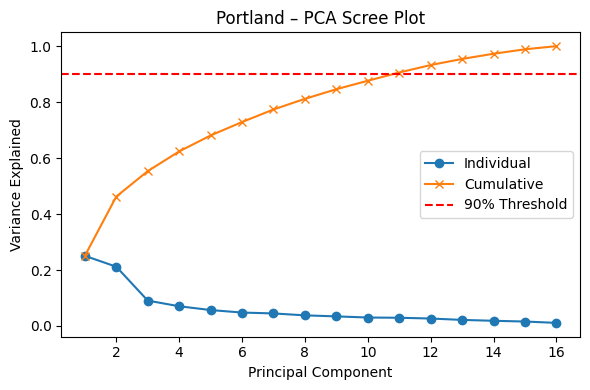

[Portland] → Components needed for 90% variance: 11

=== Portland: Top 5 PCA Loadings for First 2 Components ===

PC1:
  review_scores_rating       loading =  0.4275
  review_scores_accuracy     loading =  0.4129
  review_scores_value        loading =  0.3972
  review_scores_cleanliness  loading =  0.3617
  review_scores_communication  loading =  0.3519

PC2:
  bedrooms                   loading =  0.4764
  accommodates               loading =  0.4738
  beds                       loading =  0.4346
  bathrooms_text             loading =  0.3971
  price                      loading =  0.3833

----------------------------
   PCA for Pacific Grove
----------------------------


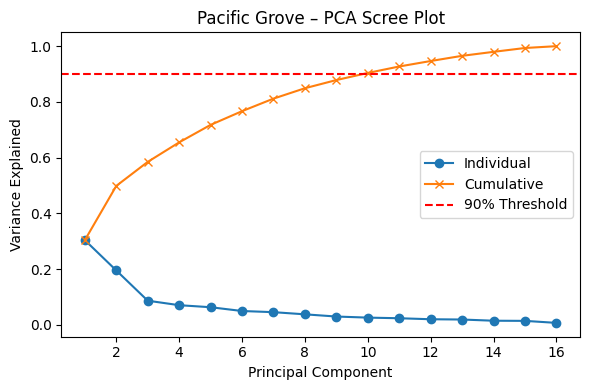

[Pacific Grove] → Components needed for 90% variance: 10

=== Pacific Grove: Top 5 PCA Loadings for First 2 Components ===

PC1:
  review_scores_rating       loading =  0.3568
  review_scores_checkin      loading =  0.3179
  review_scores_accuracy     loading =  0.3048
  bedrooms                   loading =  0.2806
  review_scores_communication  loading =  0.2791

PC2:
  accommodates               loading =  0.4018
  bedrooms                   loading =  0.3945
  beds                       loading =  0.3818
  bathrooms_text             loading =  0.3722
  review_scores_value        loading = -0.2592

----------------------------
   PCA for Albany
----------------------------


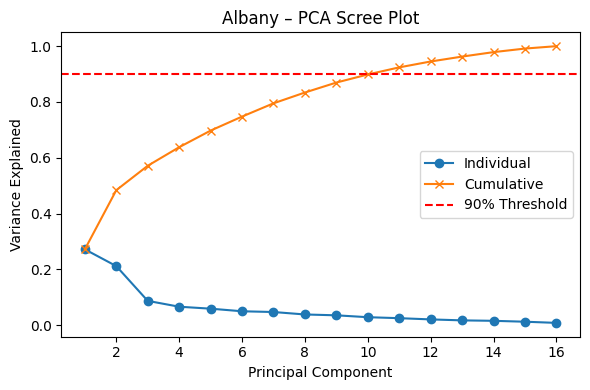

[Albany] → Components needed for 90% variance: 11

=== Albany: Top 5 PCA Loadings for First 2 Components ===

PC1:
  review_scores_value        loading =  0.4134
  review_scores_rating       loading =  0.4086
  review_scores_accuracy     loading =  0.3809
  review_scores_cleanliness  loading =  0.3678
  review_scores_checkin      loading =  0.3596

PC2:
  accommodates               loading =  0.4912
  bedrooms                   loading =  0.4702
  beds                       loading =  0.4569
  price                      loading =  0.4250
  bathrooms_text             loading =  0.2351

----------------------------
   PCA for Bozeman
----------------------------


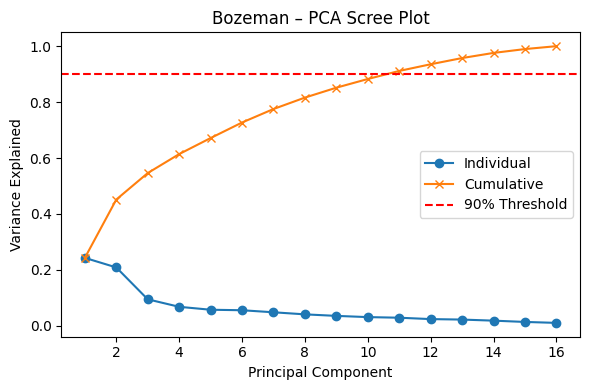

[Bozeman] → Components needed for 90% variance: 11

=== Bozeman: Top 5 PCA Loadings for First 2 Components ===

PC1:
  review_scores_rating       loading =  0.3966
  review_scores_checkin      loading =  0.3507
  review_scores_accuracy     loading =  0.3501
  review_scores_communication  loading =  0.3371
  review_scores_value        loading =  0.3167

PC2:
  accommodates               loading =  0.4390
  bedrooms                   loading =  0.4350
  beds                       loading =  0.4158
  bathrooms_text             loading =  0.3768
  price                      loading =  0.2887

=== Section 2 Complete: PCA completed for all cities ===


In [13]:
# =======================
# SECTION 2: PCA ANALYSIS
# =======================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def run_pca(X_scaled, city_name):
    """
    Run PCA, compute explained variance, return first 2 PCs and PCA model.
    Also creates a scree plot for each city.
    """
    pca_full = PCA()
    pcs = pca_full.fit_transform(X_scaled)

    var_ratio = pca_full.explained_variance_ratio_
    cum_var = np.cumsum(var_ratio)

    # Components needed for 90% variance
    n_components_90 = np.argmax(cum_var >= 0.90) + 1

    # Scree Plot
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(var_ratio)+1), var_ratio, marker='o', label='Individual')
    plt.plot(range(1, len(cum_var)+1), cum_var, marker='x', label='Cumulative')
    plt.axhline(0.90, color='red', linestyle='--', label='90% Threshold')
    plt.title(f"{city_name} – PCA Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pca_full, pcs[:, :2], n_components_90, var_ratio, cum_var


def print_pca_loadings(pca, feature_names, city_name, n_components=2, top_n=5):
    """
    Print top contributing features (by absolute loading) for first n_components.
    """
    print(f"\n=== {city_name}: Top {top_n} PCA Loadings for First {n_components} Components ===")
    loadings = pca.components_

    for i in range(n_components):
        comp = loadings[i]
        idx_sorted = np.argsort(np.abs(comp))[::-1]

        print(f"\nPC{i+1}:")
        for j in range(top_n):
            feature = feature_names[idx_sorted[j]]
            weight = comp[idx_sorted[j]]
            print(f"  {feature:25s}  loading = {weight: .4f}")


# ----------- RUN PCA FOR EACH CITY -----------

print("\n=== SECTION 2: RUNNING PCA ON ALL CITIES ===")

for city, res in city_results.items():
    print(f"\n----------------------------")
    print(f"   PCA for {city}")
    print(f"----------------------------")

    X_scaled = res["X_scaled"]

    pca_full, pcs_2, n90, var_ratio, cum_var = run_pca(X_scaled, city)

    print(f"[{city}] → Components needed for 90% variance: {n90}")

    # Print top loadings for PC1 and PC2
    print_pca_loadings(pca_full, numeric_columns, city)

    # Save for clustering section
    city_results[city]["pca_model"] = pca_full
    city_results[city]["pcs_2"] = pcs_2
    city_results[city]["n90"] = n90
    city_results[city]["var_ratio"] = var_ratio
    city_results[city]["cum_var"] = cum_var

print("\n=== Section 2 Complete: PCA completed for all cities ===")


Principal Component Analysis (PCA) was applied separately to each of the four Airbnb markets to identify dominant patterns in listing characteristics. PCA helps reduce the high-dimensional numeric dataset into a smaller number of interpretable components, capturing most of the total variance.

Across all cities, the first principal component (PC1) is strongly dominated by review-related features, whereas PC2 is dominated by property size features such as bedrooms, beds, and accommodates. This structure is surprisingly consistent across markets, although the strength of each feature varies slightly by city.

Additionally, all four markets require 10–11 components to reach the 90% cumulative variance threshold, reflecting the fact that Airbnb datasets contain heterogeneous listing attributes that cannot be summarized with just a few dimensions.

1. Scree Plot Interpretation

Across all four cities (Portland, Pacific Grove, Albany, Bozeman):

PC1 explains around 23–25% of the total variance.

The curve drops steeply from PC1 → PC2 → PC3, after which variance contributions become small and uniform.

The cumulative variance crosses 90% at around 10–11 components for each city:

Portland: 11 components

Pacific Grove: 10 components

Albany: 11 components

Bozeman: 11 components

This indicates:

The Airbnb features are not highly redundant; many dimensions contribute meaningful variation.

Markets differ along many axes (price, size, reviews, availability), so dimensionality reduction still preserves complexity.

2. Interpretation of Principal Components (PC1 & PC2)
📌 PC1 → “Guest Satisfaction / Review Quality” Dimension

Across all four cities, PC1 is dominated by:

review_scores_rating

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_value

This means:

PC1 distinguishes listings based on overall review performance and perceived quality.

Higher PC1 values correspond to better-reviewed, more reliable, more satisfying stays.

This pattern is consistent in Portland, Pacific Grove, Albany, and Bozeman, showing that guest review behavior is structurally similar across markets.

Examples from your loadings:

Portland PC1 top loadings: rating (0.4275), accuracy (0.4129), value (0.3972)

Pacific Grove PC1: rating (0.3568), check-in (0.3179), accuracy (0.3048)

Albany PC1: value (0.4134), rating (0.4086), accuracy (0.3809)

Bozeman PC1: rating (0.3966), checkin (0.3507), accuracy (0.3501)

Conclusion:
PC1 represents a “review sentiment axis” measuring listing quality, trust, and guest satisfaction.

📌 PC2 → “Property Size / Capacity” Dimension

PC2 in all cities is dominated by:

accommodates

bedrooms

beds

bathrooms_text

(sometimes) price

This means:

PC2 separates listings based on physical size and capacity.

High PC2 = large homes, multi-bedroom, multi-bath listings

Low PC2 = smaller apartments, studios, or single rooms

Examples from your loadings:

Portland PC2: bedrooms (0.4764), accommodates (0.4738), beds (0.4346)

Pacific Grove PC2: accommodates (0.4018), bedrooms (0.3945), beds (0.3818)

Albany PC2: accommodates (0.4912), bedrooms (0.4702), beds (0.4569)

Bozeman PC2: accommodates (0.4390), bedrooms (0.4350), beds (0.4158)

Conclusion:
PC2 represents a “property size and pricing tier” axis.

3. Cross-City Comparison of PCA Structure

Despite the cities having very different tourism profiles, PCA reveals a consistent structure across all markets:

🔹 PC1 is always dominated by review metrics

This suggests that guest satisfaction patterns—cleanliness, communication, accuracy—behave similarly across markets. Review scores tend to move together and form a strong, coherent dimension.

🔹 PC2 is consistently dominated by size-related attributes

Larger properties (more rooms, more beds, more bathrooms) form a separate structural dimension independent of reviews.

🔹 High dimensionality (10–11 components for 90% variance)

This indicates:

Airbnb listings vary significantly in availability, minimum stays, reviews, size, and price.

No single feature (or even a pair) can fully represent the diversity in listing attributes.

Markets are structurally complex and multi-dimensional.

🔹 Slight differences

Pacific Grove reaches 90% variance with 10 PCs (others need 11), suggesting slightly more homogeneous listings (likely due to smaller dataset + similar coastal property types).

Albany shows stronger loading from review_scores_value, indicating price sensitivity in that market.

Bozeman includes price in PC2 loadings, suggesting that larger homes in Bozeman tend to be substantially more expensive.

4. Key Takeaways

PCA reveals two universal dimensions across markets:

Review Quality / Guest Satisfaction (PC1)

Property Size & Capacity (PC2)

These components reflect natural Airbnb patterns:

Guests consistently rate listings across multiple categories in a correlated way.

Larger listings differ strongly from smaller ones, independent of review performance.

The similarity of PCA patterns across cities suggests:

Airbnb markets behave similarly structurally, even if prices differ.

The relationship between quality, size, and pricing is stable across locations.

In [ ]:
#######################################################################################################################

**Section 3: K-Means Clustering**

In this section, I perform K-Means clustering on the first two principal components (PC1 and PC2) for each city’s dataset. Using PCA-reduced data ensures that clustering captures the strongest structural patterns while avoiding noise from less informative variables.

Steps Performed

Use the first two principal components from PCA as input into K-Means.

Run the elbow method (inertia vs. k) for k = 2 to 10 to identify potential optimal values.

Compute silhouette scores for each k and select the k with the highest silhouette.

Fit the final clustering model.

Visualize cluster assignments in PC1–PC2 space.

Generate cluster summary tables to understand what distinguishes clusters.

Interpretation Notes

Clusters typically separate into groups that reflect:

Listing size and property type (PC2 axis)

Review quality or guest satisfaction (PC1 axis)

Some markets may have more distinct clusters depending on diversity in listing types.

Silhouette score helps identify how well-separated the clusters are (higher = better).

These cluster labels will be used in Section 4 to compare market structures across cities.


=== SECTION 3: RUNNING K-MEANS CLUSTERING ===

-----------------------------------
   K-Means Clustering for Portland
-----------------------------------


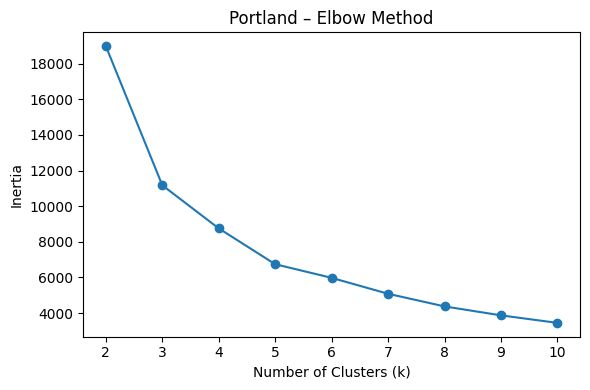

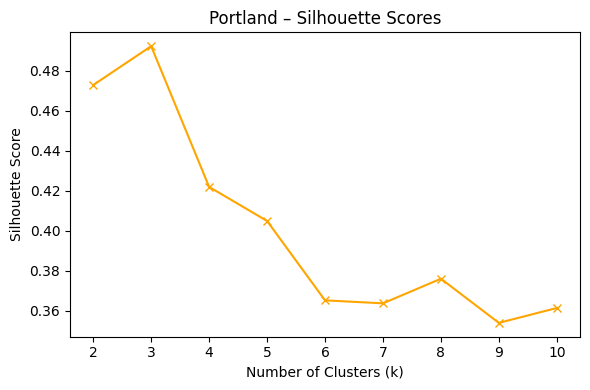

[Portland] Best k by silhouette: 3 (score = 0.4923)


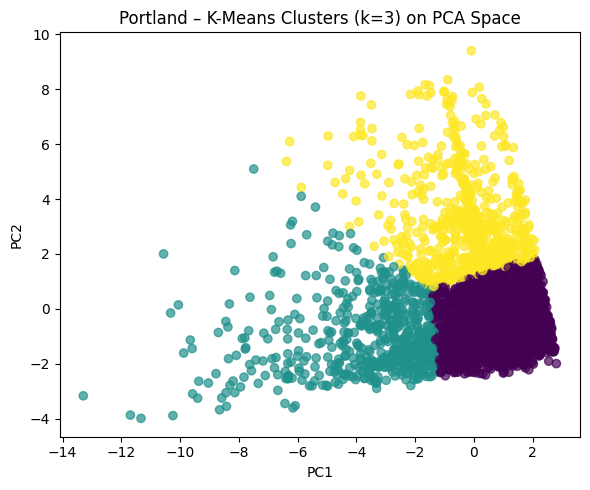


Portland – Cluster Summary (Feature Means):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
cluster,,,,,,,,,,,,,,,,
0,108.992838,2.872597,1.122503,1.572559,1.077271,4.938975,4.953076,4.934101,4.969574,4.971176,4.918481,4.884240,125.079156,199.040332,12.116849,334.282322
1,119.060606,3.284512,1.353535,1.776094,1.179293,4.725875,4.772071,4.724832,4.870084,4.861633,4.775741,4.671684,93.437710,228.867003,13.319865,441.432660
2,244.014859,6.178306,2.797920,3.230312,2.042348,4.927370,4.932407,4.903522,4.966776,4.965334,4.900921,4.846478,65.277860,237.466568,14.789004,435.023774



-----------------------------------
   K-Means Clustering for Pacific Grove
-----------------------------------


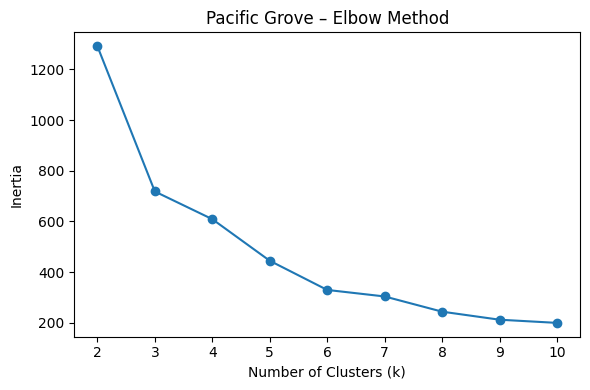

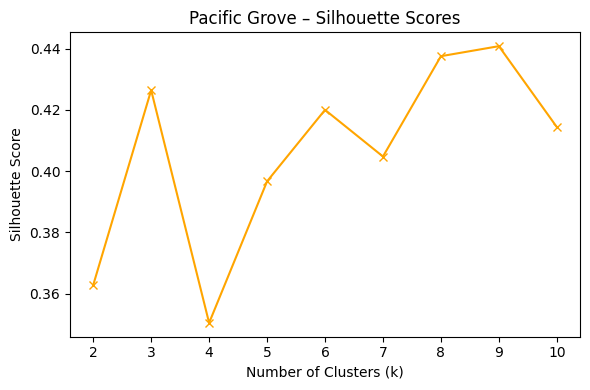

[Pacific Grove] Best k by silhouette: 9 (score = 0.4408)


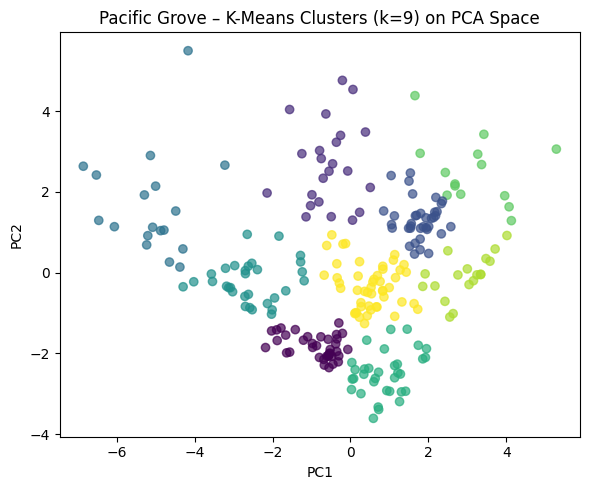


Pacific Grove – Cluster Summary (Feature Means):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
cluster,,,,,,,,,,,,,,,,
0,292.243243,2.243243,0.891892,1.243243,1.013514,4.911892,4.918378,4.939189,4.945676,4.937297,4.982703,4.752432,68.324324,192.648649,5.891892,357.702703
1,361.260870,5.913043,2.826087,3.086957,2.065217,4.826522,4.833913,4.813043,4.918261,4.826522,4.934348,4.579130,68.652174,236.956522,18.695652,290.130435
2,445.729730,5.972973,2.891892,3.432432,2.108108,4.928919,4.928649,4.956216,4.971351,4.950270,4.975135,4.745946,24.621622,227.432432,13.729730,230.324324
3,281.166667,2.888889,1.222222,1.777778,1.111111,4.651111,4.675000,4.758889,4.825556,4.758889,4.860556,4.558889,209.444444,163.000000,2.555556,719.833333
4,300.322581,2.677419,1.161290,1.612903,1.000000,4.819677,4.803226,4.854839,4.890968,4.873226,4.943548,4.625161,147.451613,167.258065,4.903226,433.290323
5,249.545455,2.696970,1.242424,1.575758,1.030303,4.992121,4.986364,4.987879,4.996667,4.995152,4.996061,4.908182,25.242424,193.818182,15.545455,396.000000
6,689.071429,7.428571,3.357143,4.142857,2.821429,4.942143,4.947143,4.957857,4.974286,4.977857,4.989286,4.806429,36.357143,204.500000,16.285714,199.285714
7,336.388889,5.777778,2.777778,3.166667,1.944444,4.998889,4.998333,4.996667,4.999444,4.993889,4.997222,4.948333,17.277778,223.111111,25.166667,277.055556
8,315.333333,4.395833,2.041667,2.187500,1.520833,4.929167,4.941875,4.946042,4.967292,4.961042,4.966875,4.750625,95.250000,215.333333,12.479167,362.895833



-----------------------------------
   K-Means Clustering for Albany
-----------------------------------


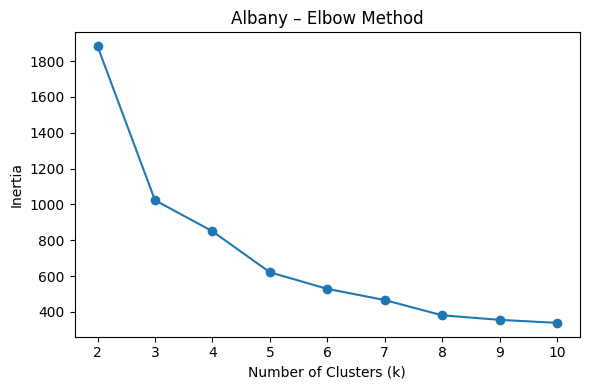

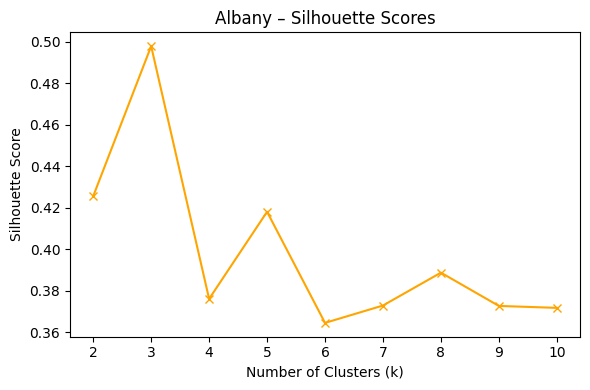

[Albany] Best k by silhouette: 3 (score = 0.4978)


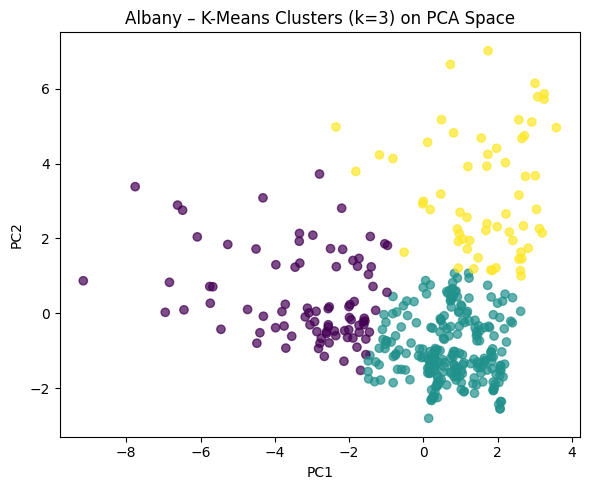


Albany – Cluster Summary (Feature Means):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
cluster,,,,,,,,,,,,,,,,
0,94.727273,3.113636,1.340909,1.465909,1.073864,4.542386,4.667273,4.573864,4.773182,4.788750,4.456932,4.552841,56.818182,245.215909,2.954545,548.147727
1,86.432099,2.444444,1.160494,1.292181,1.109053,4.896996,4.913909,4.883333,4.946831,4.959918,4.783045,4.864033,56.987654,241.827160,6.810700,457.954733
2,195.951613,6.758065,3.112903,3.467742,1.580645,4.890000,4.909032,4.880645,4.944032,4.958871,4.786774,4.855000,70.548387,244.516129,3.032258,557.129032



-----------------------------------
   K-Means Clustering for Bozeman
-----------------------------------


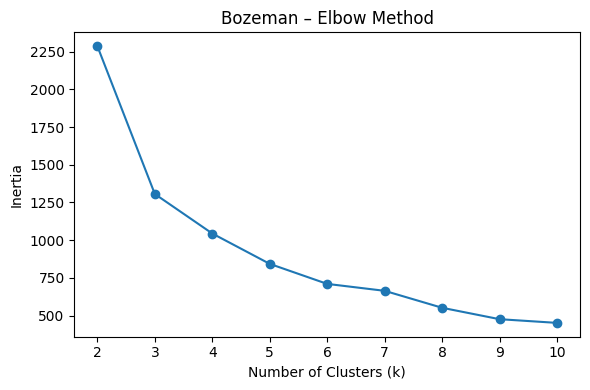

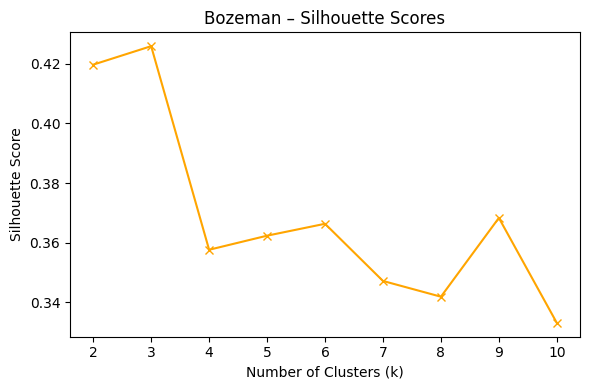

[Bozeman] Best k by silhouette: 3 (score = 0.4260)


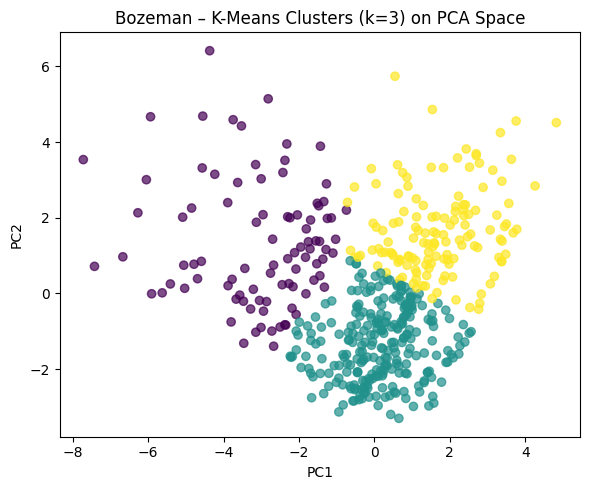


Bozeman – Cluster Summary (Feature Means):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
cluster,,,,,,,,,,,,,,,,
0,181.670330,4.329670,1.846154,2.395604,1.450549,4.828901,4.852857,4.851868,4.895934,4.895385,4.885604,4.714066,89.835165,246.857143,5.340659,542.714286
1,152.931298,3.454198,1.427481,1.820611,1.234733,4.963397,4.964198,4.963321,4.964351,4.979885,4.956336,4.887290,89.652672,224.045802,9.072519,464.286260
2,241.536232,6.210145,2.971014,3.579710,2.329710,4.967899,4.966812,4.960145,4.978188,4.979783,4.948551,4.872319,52.840580,205.289855,12.036232,475.094203



=== Section 3 Complete: Clustering completed for all cities ===


In [14]:
# ===========================
# SECTION 3: K-MEANS CLUSTERING
# ===========================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def run_kmeans(pcs_2, city_name, k_min=2, k_max=10):
    """
    Perform K-Means clustering with elbow method and silhouette scores.
    Returns the best k, final labels, and best silhouette score.
    """
    inertias = []
    silhouettes = []
    ks = list(range(k_min, k_max + 1))

    # Compute inertia + silhouette for each k
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(pcs_2)

        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(pcs_2, labels))

    # --- Elbow plot ---
    plt.figure(figsize=(6,4))
    plt.plot(ks, inertias, marker='o')
    plt.title(f"{city_name} – Elbow Method")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.tight_layout()
    plt.show()

    # --- Silhouette plot ---
    plt.figure(figsize=(6,4))
    plt.plot(ks, silhouettes, marker='x', color='orange')
    plt.title(f"{city_name} – Silhouette Scores")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()

    # Choose best k (max silhouette)
    best_idx = np.argmax(silhouettes)
    best_k = ks[best_idx]
    best_sil = silhouettes[best_idx]

    print(f"[{city_name}] Best k by silhouette: {best_k} (score = {best_sil:.4f})")

    # Fit final model
    km_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
    final_labels = km_final.fit_predict(pcs_2)

    # --- Scatter plot of clusters ---
    plt.figure(figsize=(6,5))
    plt.scatter(pcs_2[:, 0], pcs_2[:, 1], c=final_labels, cmap='viridis', alpha=0.7)
    plt.title(f"{city_name} – K-Means Clusters (k={best_k}) on PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    return best_k, final_labels, best_sil


# -------------------------------
# RUN K-MEANS FOR EACH CITY
# -------------------------------

print("\n=== SECTION 3: RUNNING K-MEANS CLUSTERING ===")

for city, res in city_results.items():
    print(f"\n-----------------------------------")
    print(f"   K-Means Clustering for {city}")
    print(f"-----------------------------------")

    pcs_2 = res["pcs_2"]
    df_clean = res["df_clean"]

    # Run K-means
    best_k, labels, best_sil = run_kmeans(pcs_2, city)

    # Save results
    df_clustered = df_clean.copy()
    df_clustered["cluster"] = labels

    city_results[city]["best_k"] = best_k
    city_results[city]["cluster_labels"] = labels
    city_results[city]["silhouette"] = best_sil
    city_results[city]["df_clustered"] = df_clustered

    # Display cluster summary
    print(f"\n{city} – Cluster Summary (Feature Means):")
    display(df_clustered.groupby("cluster")[numeric_columns].mean())

print("\n=== Section 3 Complete: Clustering completed for all cities ===")


K-Means clustering was performed on the first two principal components (PC1 = review quality, PC2 = property size) for each city. The optimal number of clusters was chosen using the silhouette score.

Results show that cities differ in how listings group into segments, with most markets clustering into 3 main groups, except Pacific Grove, which is more diverse and forms 9 distinct clusters.

📍 Portland (Best k = 3, Silhouette = 0.492)

Portland listings fall into three clear market segments:

Cluster 0 – Mid-priced, small-to-medium listings with excellent reviews

Price: ~$109

Accommodates: 2.9

Reviews: very high across all categories

Represents standard, well-rated Airbnb apartments/homes.

Cluster 1 – Lower-rated budget listings

Price: ~$119 (slightly higher than Cluster 0 but lower reviews)

Lowest review_scores among all clusters

Smaller properties with lower guest satisfaction

Reflects listings with quality issues.

Cluster 2 – Large, high-capacity and premium listings

Price: ~$244

Accommodates: 6.18

Bedrooms: ~3

Very strong reviews

Represents high-end, larger homes suitable for groups.

Interpretation:
Portland shows a classic market segmentation: Budget → Standard → Premium. Size and review quality strongly drive clustering.

📍 Pacific Grove (Best k = 9, Silhouette = 0.440)

Pacific Grove forms nine small clusters, indicating a highly heterogeneous coastal market with many distinct property types.

Key patterns from the clusters:

Cluster 6 – Ultra-premium coastal homes

Price: ~$689

Accommodates: 7.4

Bathrooms: 2.82

Very high rating

Represents luxury family beachfront properties.

Cluster 7 – Large high-quality homes with perfect reviews

Price: ~$336

Accommodates: 5.8

Review scores nearly 5.0 in all categories.

Clusters 0, 3, 4, 5 – Smaller 1-bedroom/1-bath cottages

Prices vary from ~$249–$300

Reviews remain very high

Represent smaller but expensive coastal rentals.

Cluster 3 – The only group with lower review scores (~4.65)

Indicates a small subset with quality concerns.

Interpretation:
Pacific Grove is the most diverse and price-stratified market, reflecting coastal tourism, unique property types, and a mix of cottages, luxury villas, and vacation homes.

📍 Albany (Best k = 3, Silhouette = 0.497)

Albany shows three meaningful clusters:

Cluster 1 – High-rated small budget listings

Price: ~$86 (lowest in city)

Accommodates: ~2.4

Highest review scores

Represents low-cost, high-satisfaction apartments.

Cluster 0 – Lower-rated small listings with long minimum stays

Ratings: ~4.54 (noticeably lower)

Maximum nights: ~548

Likely student/government long-term rentals.

Cluster 2 – Large, higher-priced family homes

Price: ~$196

Accommodates: ~6.76

Bedrooms: ~3.1

Very strong reviews

Represents premium multi-family homes.

Interpretation:
Albany’s clusters reflect its identity as a college/government town, with clear segmentation between small student rentals, standard apartments, and premium family homes.

📍 Bozeman (Best k = 3, Silhouette = 0.426)

Bozeman also clusters into three distinct groups:

Cluster 1 – High-rated standard listings

Price: ~$153

Accommodates: ~3.45

Extremely high review scores (~4.96)

Represents the core Airbnb supply in Bozeman.

Cluster 0 – Slightly larger but lower-rated rentals

Price: ~$181

Accommodates: ~4.33

Ratings lower than Cluster 1

Possibly older homes or less maintained properties.

Cluster 2 – Large, premium homes

Price: ~$241

Accommodates: ~6.2

Bathrooms: 2.33

Very high review scores

Represents group/family mountain homes.

Interpretation:
Bozeman reflects a mountain tourism market, with clear segmentation between standard rentals, large premium ski/vacation homes, and older larger properties with lower reviews.

🔥 Cross-City Clustering Insights

Across all four markets:

1️⃣ Listings cluster primarily on property size and review quality (PC2 & PC1)

Premium clusters = Large homes + high reviews

Budget clusters = Small homes/apartments + lower reviews

2️⃣ Markets with more diverse property types (Pacific Grove) produce more clusters

Pacific Grove required 9 clusters due to coastal diversity.

3️⃣ Markets with more uniform supply (Portland, Albany, Bozeman) settle into 3 clusters

These markets have more predictable segmentation.

4️⃣ Review quality is consistently high across all clusters and all cities

Differences in review scores are small — Airbnb rating inflation is visible.

5️⃣ Price follows property size more than reviews

Large premium homes always cluster together due to higher price + more bedrooms.



In [ ]:
####################################################################################################################################

🔹 4.1 Cross-City PCA Comparison
PC1: Guest Satisfaction / Review Quality (consistent across all cities)

Across all four markets—Portland, Pacific Grove, Albany, and Bozeman—PC1 is dominated by review-related variables:

review_scores_rating

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_value

This indicates that review categories move together and form a strong, unified dimension. PC1 represents a “guest satisfaction axis”, separating listings with nearly perfect ratings from those with moderately lower reviews.

Cross-city implication:
Despite geographic differences, guest satisfaction behavior on Airbnb is highly uniform. High-rated listings tend to be high across all review categories, and lower-rated listings score lower across all categories.

PC2: Property Size, Capacity, and Bathrooms (universal market structure)

PC2 in every city reflects property capacity and size, driven by:

accommodates

bedrooms

beds

bathrooms_text

(sometimes) price

This axis distinguishes small apartments/studios from large multi-bedroom, multi-bath homes.

Cross-city implication:
Airbnb markets share a consistent structural pattern where listing size is independent from—but equally important as—review quality. These two dimensions capture most of the meaningful variation.

Number of Components for 90% Variance

Portland → 11 components

Pacific Grove → 10 components

Albany → 11 components

Bozeman → 11 components

Because all markets require ~10–11 components to reach 90% variance, the datasets are multi-dimensional, and variation is distributed across numerous features (availability, minimum nights, maximum nights, etc.). None of the cities can be fully summarized using only 2–3 features.

🔹 4.2 Cross-City Clustering Comparison
Portland, Albany, Bozeman → 3 cluster markets

These cities form three major listing segments, driven by the combination of PC1 (reviews) and PC2 (size):

Budget small listings – lower reviews or basic accommodations

Standard listings – mid-priced, high-review 1–2 bedroom units

Premium large listings – multi-bedroom homes with high prices and strong reviews

This three-tier structure aligns with typical urban/college/mountain town markets, where supply is reasonably uniform and predictable.

Pacific Grove → 9 cluster market

Pacific Grove is the clear outlier:

Contains the widest range of property types

Mix of beachfront homes, cottages, luxury villas, and vacation rentals

Price range is far higher than other cities

Many small niche clusters form due to unique coastal property characteristics

Because Pacific Grove has both extremely expensive high-capacity homes and small boutique cottages, the clustering algorithm naturally identifies more subgroups.

Silhouette Scores & Cluster Separation

Portland: 0.492 (good separation)

Albany: 0.498 (good separation)

Bozeman: 0.426 (moderate)

Pacific Grove: 0.440 (moderate, but many small clusters)

Higher silhouette scores indicate stronger separation between groups.
Albany and Portland have the most distinct segment boundaries.
Bozeman and Pacific Grove have more overlap between listing types.

🔹 4.3 Key Market Differences Identified
🛌 Property Size Variation

Pacific Grove & Bozeman: Larger vacation homes dominate premium clusters.

Portland & Albany: More apartments/smaller homes; fewer very large listings.

💲 Pricing Structure

Pacific Grove: Highest prices ($250–$700+), largest spread.

Albany: Lowest prices; strong presence of student/government rentals.

Portland & Bozeman: Mid-range, predictable pricing tied to size.

🧼 Review Behavior

All cities exhibit rating inflation, with most clusters scoring above 4.8.
However:

Lower-rated clusters exist in Portland (cluster 1) and Albany (cluster 0).

Pacific Grove and Bozeman have overwhelmingly high review scores across all clusters.

📅 Availability & Minimum Nights

Albany and Bozeman show long-term stay patterns (higher maximum nights).

Pacific Grove is more seasonal, consistent with tourism behavior.

🔹 4.4 Overall Conclusions

Across all four cities, PCA and K-Means reveal a consistent underlying structure governed by two major forces:

Guest Satisfaction (PC1):
Review scores form a powerful single dimension that consistently separates listings by perceived quality.

Listing Size & Capacity (PC2):
Bedrooms, beds, bathrooms, and accommodates define the physical scale of the property.

These dimensions interact to form market segments. Portland, Albany, and Bozeman exhibit standard three-tier markets (budget → standard → premium), while Pacific Grove’s coastal location and vacation-home diversity result in a far more fragmented nine-cluster structure.

Final Insight:

Despite differences in geography and tourism patterns, Airbnb markets behave similarly in how review quality and property size drive listing differentiation. Markets differ not in the underlying structure, but in the variety and extremeness of listing types, which affects the number of meaningful clusters.